This notebook is to train Flow Matching model into Model Parameters dataset to conditionally generate model parameters on angle

In [2]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from tqdm.notebook import tqdm

from src.model.models import Flow
from src.data.helpers import get_moons_dataset, rotate, get_accuracy, generate_flow
from src.visualization.visualize import plot_decision_boundary
from src.data.datasets import ModelParamsDataset

In [3]:
def compute_conditional_vector_field(x0, x1):
    return x1 - x0


def sample_conditional_pt(x0, x1, t, sigma):
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

## Regular (10000 samples per angle)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 500
lr = 1e-3
batch_size = 100

torch.manual_seed(0)

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow()
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 33
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))

path = "../../models/generators/flow_matching/"
model_path = path + "flow_conditional.pth"

In [17]:
losses = []
accuracies_per_epoch = []
angles = [0, 45, 90, 135, 180, 225, 270, 315, 45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

for epoch in tqdm(range(epochs)):    
    for X, y in dataloader:
        optimizer.zero_grad()
        x0 = gaussian.sample((batch_size,)).to(device)
        x1 = X.to(device)

        t = torch.rand(x0.shape[0]).type_as(x0).to(device)

        y = y * torch.pi / 180
        sin = torch.sin(y).to(device)
        cos = torch.cos(y).to(device)

        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)        

        vt = flow(torch.cat([xt, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())

    if epoch % 100 == 0:
        flow.to("cpu")
        accuracies = []
        with torch.no_grad():
            for angle in angles:
                for i in range(10):
                    x = generate_flow(flow, angle)
                    x = torch.tensor(x, dtype=torch.float32)

                    X, y = get_moons_dataset()
                    X_rotated = rotate(X, angle)
                    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                    accuracy = get_accuracy(x, X_rotated, y)
                    accuracies.append(accuracy)
            
            accuracies_per_epoch.append(np.mean(accuracies))
            torch.save(flow.state_dict(), f"{path}flow_matching_{epoch}.pth")
        flow.to(device)

torch.save(flow.state_dict(), model_path)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Loss 3.7666163444519043


C:\Users\JetFire\AppData\Local\Temp\ipykernel_20252\449921296.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epoch 10: Loss 3.048095941543579
Epoch 20: Loss 3.3158020973205566
Epoch 30: Loss 2.9104456901550293
Epoch 40: Loss 3.000023126602173
Epoch 50: Loss 2.656207323074341
Epoch 60: Loss 2.6449148654937744
Epoch 70: Loss 2.719987392425537
Epoch 80: Loss 2.664802312850952
Epoch 90: Loss 2.842017889022827
Epoch 100: Loss 2.962918996810913
Epoch 110: Loss 2.7913405895233154
Epoch 120: Loss 2.8683576583862305
Epoch 130: Loss 2.734318733215332
Epoch 140: Loss 2.6588544845581055
Epoch 150: Loss 2.511068344116211
Epoch 160: Loss 2.8392086029052734
Epoch 170: Loss 2.656672716140747
Epoch 180: Loss 2.797926425933838
Epoch 190: Loss 2.8749263286590576
Epoch 200: Loss 2.1190342903137207
Epoch 210: Loss 2.75994610786438
Epoch 220: Loss 2.694634199142456
Epoch 230: Loss 3.1545186042785645
Epoch 240: Loss 2.9557135105133057
Epoch 250: Loss 2.6899328231811523
Epoch 260: Loss 2.4361557960510254
Epoch 270: Loss 2.635899543762207
Epoch 280: Loss 2.617363691329956
Epoch 290: Loss 2.844223737716675
Epoch 300: 

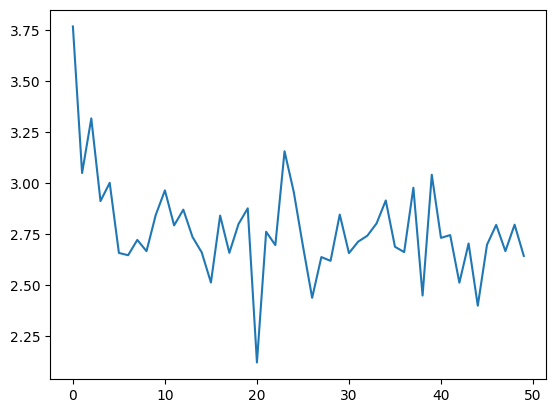

In [18]:
plt.plot(losses)

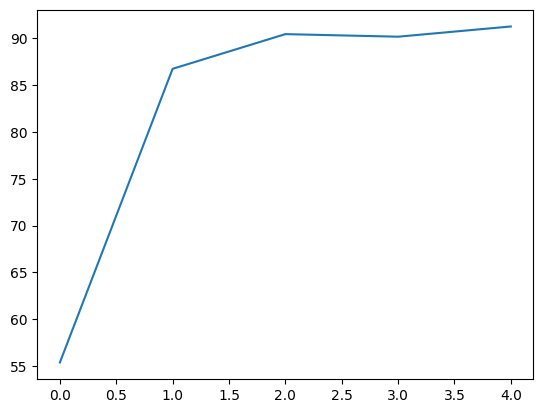

In [19]:
plt.plot(accuracies_per_epoch)


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_20252\3820484503.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 91.57079999999999


<Axes: ylabel='Density'>

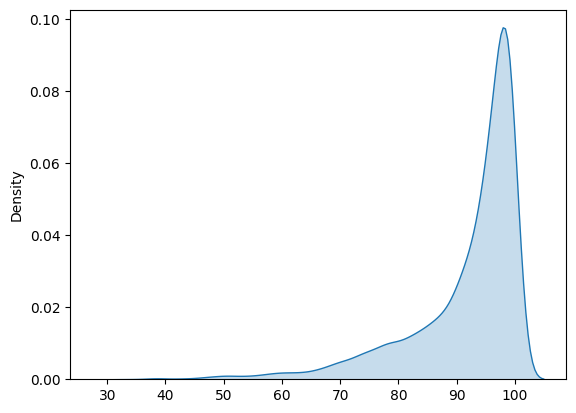

In [21]:
flow = Flow()
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate_flow(flow, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_20252\37579770.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 90.36385


<Axes: ylabel='Density'>

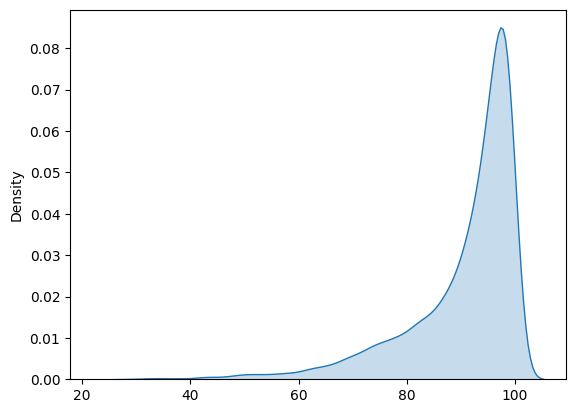

In [22]:
flow = Flow()
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate_flow(flow, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

## 10 Samples per angle

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 5000
lr = 1e-3
batch_size = 20

torch.manual_seed(0)

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv", get_per_angle=10)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow()
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 33
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))

path = "../../models/generators/flow_matching/"
model_path = path + "flow_conditional_10spa.pth"

In [52]:
losses = []
accuracies_per_epoch = []
angles = [0, 45, 90, 135, 180, 225, 270, 315, 45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

for epoch in tqdm(range(epochs)):    
    for X, y in dataloader:
        optimizer.zero_grad()
        x0 = gaussian.sample((batch_size,)).to(device)
        x1 = X.to(device)

        t = torch.rand(x0.shape[0]).type_as(x0).to(device)

        y = y * torch.pi / 180
        sin = torch.sin(y).to(device)
        cos = torch.cos(y).to(device)

        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)        

        vt = flow(torch.cat([xt, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())

    if epoch % 500 == 0:
        flow.to("cpu")
        accuracies = []
        with torch.no_grad():
            for angle in angles:
                for i in range(10):
                    x = generate_flow(flow, angle)
                    x = torch.tensor(x, dtype=torch.float32)

                    X, y = get_moons_dataset()
                    X_rotated = rotate(X, angle)
                    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                    accuracy = get_accuracy(x, X_rotated, y)
                    accuracies.append(accuracy)
            
            accuracies_per_epoch.append(np.mean(accuracies))
        flow.to(device)

torch.save(flow.state_dict(), model_path)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Loss 5.494711399078369


C:\Users\JetFire\AppData\Local\Temp\ipykernel_9608\655630411.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epoch 10: Loss 3.330134153366089
Epoch 20: Loss 3.67144775390625
Epoch 30: Loss 3.4569363594055176
Epoch 40: Loss 3.798456907272339
Epoch 50: Loss 3.5202221870422363
Epoch 60: Loss 4.156877040863037
Epoch 70: Loss 3.7063729763031006
Epoch 80: Loss 3.4860661029815674
Epoch 90: Loss 3.7890541553497314
Epoch 100: Loss 4.08849573135376
Epoch 110: Loss 3.8439371585845947
Epoch 120: Loss 2.6423239707946777
Epoch 130: Loss 1.9436970949172974
Epoch 140: Loss 2.614255428314209
Epoch 150: Loss 2.739576578140259
Epoch 160: Loss 2.939805269241333
Epoch 170: Loss 2.9861795902252197
Epoch 180: Loss 3.264230251312256
Epoch 190: Loss 2.3582961559295654
Epoch 200: Loss 2.2304084300994873
Epoch 210: Loss 2.7706375122070312
Epoch 220: Loss 2.3012990951538086
Epoch 230: Loss 3.225221872329712
Epoch 240: Loss 2.0161192417144775
Epoch 250: Loss 3.1327645778656006
Epoch 260: Loss 2.7218661308288574
Epoch 270: Loss 1.9600496292114258
Epoch 280: Loss 2.203444242477417
Epoch 290: Loss 3.543649196624756
Epoch 30

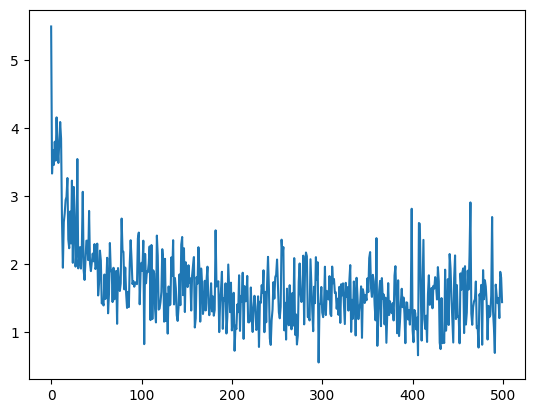

In [53]:
plt.plot(losses)

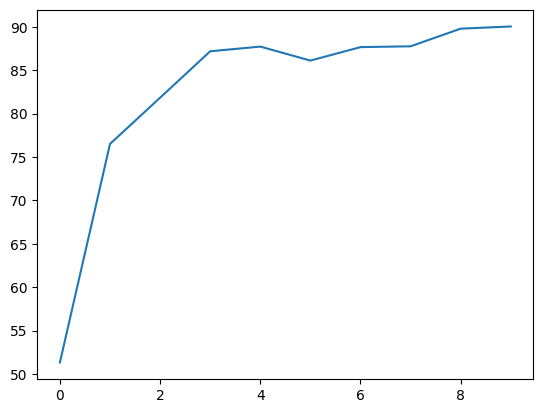

In [54]:
plt.plot(accuracies_per_epoch)


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_9608\3820484503.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 92.3883875


<Axes: ylabel='Density'>

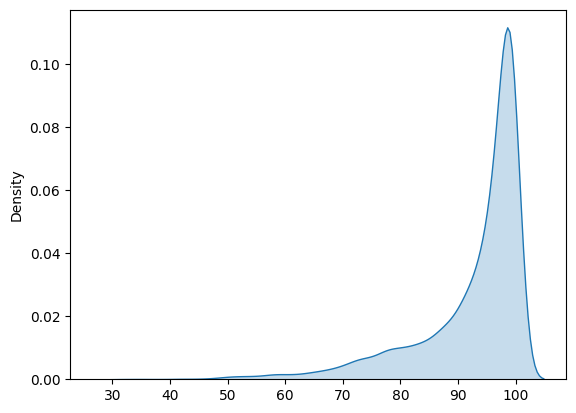

In [55]:
flow = Flow()
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate_flow(flow, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_9608\37579770.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 86.0698125


<Axes: ylabel='Density'>

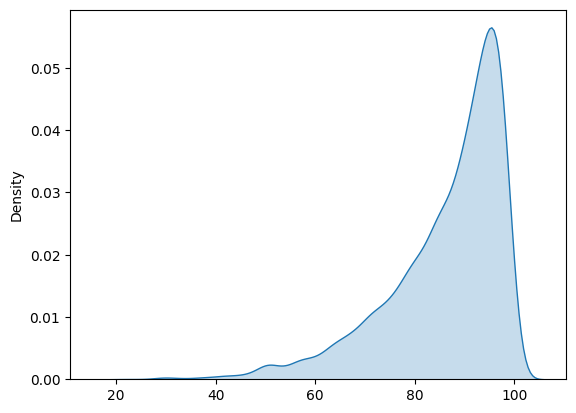

In [56]:
flow = Flow()
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate_flow(flow, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

## 20 Samples per angle

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 500
lr = 1e-3
batch_size = 20

torch.manual_seed(0)

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv", get_per_angle=20)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow()
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 33
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))

path = "../../models/generators/flow_matching/"
model_path = path + "flow_conditional_20spa.pth"

## 100 Samples per angle

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 5000
lr = 1e-3
batch_size = 100

torch.manual_seed(0)

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv", get_per_angle=100)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow()
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 33
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))

path = "../../models/generators/flow_matching/"
model_path = path + "flow_conditional_100spa.pth"

In [26]:
losses = []
accuracies_per_epoch = []
angles = [0, 45, 90, 135, 180, 225, 270, 315, 45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

for epoch in tqdm(range(epochs)):    
    for X, y in dataloader:
        optimizer.zero_grad()
        x0 = gaussian.sample((batch_size,)).to(device)
        x1 = X.to(device)

        t = torch.rand(x0.shape[0]).type_as(x0).to(device)

        y = y * torch.pi / 180
        sin = torch.sin(y).to(device)
        cos = torch.cos(y).to(device)

        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)        

        vt = flow(torch.cat([xt, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())

    if epoch % 500 == 0:
        flow.to("cpu")
        accuracies = []
        with torch.no_grad():
            for angle in angles:
                for i in range(10):
                    x = generate_flow(flow, angle)
                    x = torch.tensor(x, dtype=torch.float32)

                    X, y = get_moons_dataset()
                    X_rotated = rotate(X, angle)
                    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                    accuracy = get_accuracy(x, X_rotated, y)
                    accuracies.append(accuracy)
            
            accuracies_per_epoch.append(np.mean(accuracies))
        flow.to(device)

torch.save(flow.state_dict(), model_path)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0: Loss 4.587459087371826


C:\Users\JetFire\AppData\Local\Temp\ipykernel_4952\655630411.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epoch 10: Loss 4.377927780151367
Epoch 20: Loss 4.126352310180664
Epoch 30: Loss 3.8266944885253906
Epoch 40: Loss 3.8141233921051025
Epoch 50: Loss 3.5127410888671875
Epoch 60: Loss 3.4257149696350098
Epoch 70: Loss 3.5908243656158447
Epoch 80: Loss 3.730684518814087
Epoch 90: Loss 3.8159267902374268
Epoch 100: Loss 3.865680694580078
Epoch 110: Loss 3.538445234298706
Epoch 120: Loss 3.4041903018951416
Epoch 130: Loss 3.332318067550659
Epoch 140: Loss 3.5808398723602295
Epoch 150: Loss 3.283418655395508
Epoch 160: Loss 3.177966594696045
Epoch 170: Loss 3.5001912117004395
Epoch 180: Loss 3.4282262325286865
Epoch 190: Loss 3.3817193508148193
Epoch 200: Loss 3.172870635986328
Epoch 210: Loss 3.3049745559692383
Epoch 220: Loss 3.0143866539001465
Epoch 230: Loss 3.261904239654541
Epoch 240: Loss 3.1056621074676514
Epoch 250: Loss 2.992368698120117
Epoch 260: Loss 3.009878158569336
Epoch 270: Loss 3.1949567794799805
Epoch 280: Loss 3.0247178077697754
Epoch 290: Loss 2.9688215255737305
Epoch 

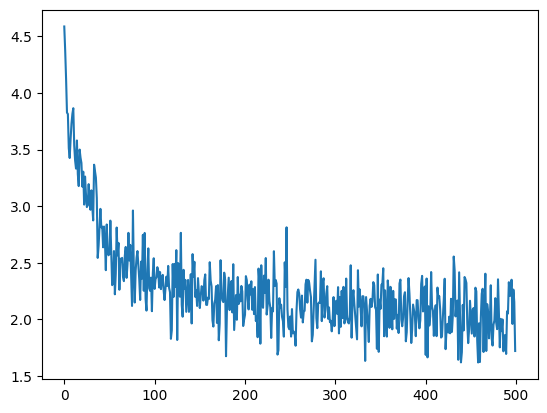

In [31]:
plt.plot(losses)

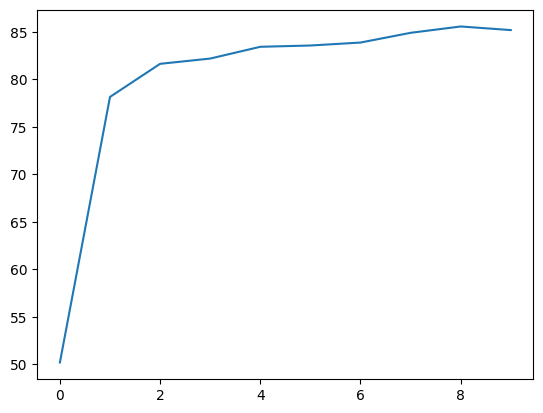

In [28]:
plt.plot(accuracies_per_epoch)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_4952\3820484503.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 85.87819999999999


<Axes: ylabel='Density'>

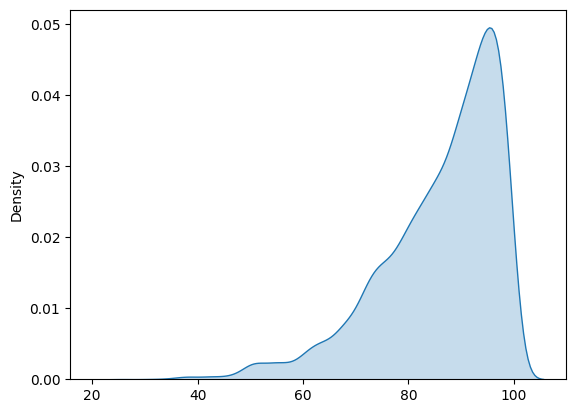

In [29]:
flow = Flow()
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate_flow(flow, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_4952\37579770.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 84.6334


<Axes: ylabel='Density'>

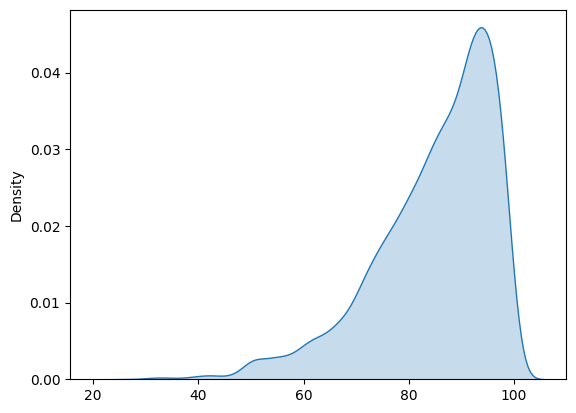

In [30]:
flow = Flow()
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate_flow(flow, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

## 1000 Samples per angle

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 2000
lr = 1e-3
batch_size = 100

torch.manual_seed(0)

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv", get_per_angle=1000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow()
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 33
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))

path = "../../models/generators/flow_matching/"
model_path = path + "flow_conditional_1000spa.pth"

In [74]:
losses = []
accuracies_per_epoch = []
angles = [0, 45, 90, 135, 180, 225, 270, 315, 45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

for epoch in tqdm(range(epochs)):    
    for X, y in dataloader:
        optimizer.zero_grad()
        x0 = gaussian.sample((batch_size,)).to(device)
        x1 = X.to(device)

        t = torch.rand(x0.shape[0]).type_as(x0).to(device)

        y = y * torch.pi / 180
        sin = torch.sin(y).to(device)
        cos = torch.cos(y).to(device)

        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)        

        vt = flow(torch.cat([xt, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())

    if epoch % 100 == 0:
        flow.to("cpu")
        accuracies = []
        with torch.no_grad():
            for angle in angles:
                for i in range(10):
                    x = generate_flow(flow, angle)
                    x = torch.tensor(x, dtype=torch.float32)

                    X, y = get_moons_dataset()
                    X_rotated = rotate(X, angle)
                    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                    accuracy = get_accuracy(x, X_rotated, y)
                    accuracies.append(accuracy)
            
            accuracies_per_epoch.append(np.mean(accuracies))
        flow.to(device)

torch.save(flow.state_dict(), model_path)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 0: Loss 4.767604351043701


C:\Users\JetFire\AppData\Local\Temp\ipykernel_9608\3316850235.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epoch 10: Loss 3.577608585357666
Epoch 20: Loss 3.3672025203704834
Epoch 30: Loss 3.1879210472106934
Epoch 40: Loss 3.270387649536133
Epoch 50: Loss 3.540024518966675
Epoch 60: Loss 2.9804396629333496
Epoch 70: Loss 3.313385248184204
Epoch 80: Loss 2.939222574234009
Epoch 90: Loss 2.9431371688842773
Epoch 100: Loss 3.019155979156494
Epoch 110: Loss 3.0897269248962402
Epoch 120: Loss 2.814516544342041
Epoch 130: Loss 2.9835169315338135
Epoch 140: Loss 3.3148937225341797
Epoch 150: Loss 3.01186203956604
Epoch 160: Loss 3.108644485473633
Epoch 170: Loss 2.821439504623413
Epoch 180: Loss 2.8444714546203613
Epoch 190: Loss 2.855764150619507
Epoch 200: Loss 2.939448356628418
Epoch 210: Loss 2.799022912979126
Epoch 220: Loss 3.1448497772216797
Epoch 230: Loss 3.0404231548309326
Epoch 240: Loss 2.596250534057617
Epoch 250: Loss 3.2492194175720215
Epoch 260: Loss 2.767873764038086
Epoch 270: Loss 2.9102776050567627
Epoch 280: Loss 3.1625924110412598
Epoch 290: Loss 2.8975279331207275
Epoch 300:

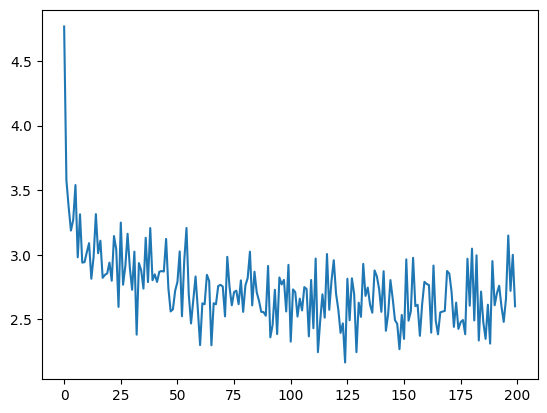

In [75]:
plt.plot(losses)

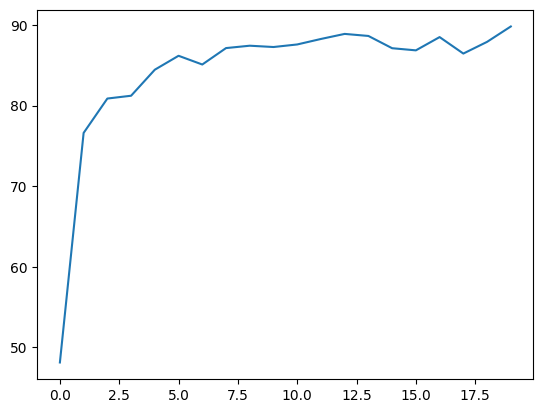

In [76]:
plt.plot(accuracies_per_epoch)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_9608\3820484503.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 88.5825875


<Axes: ylabel='Density'>

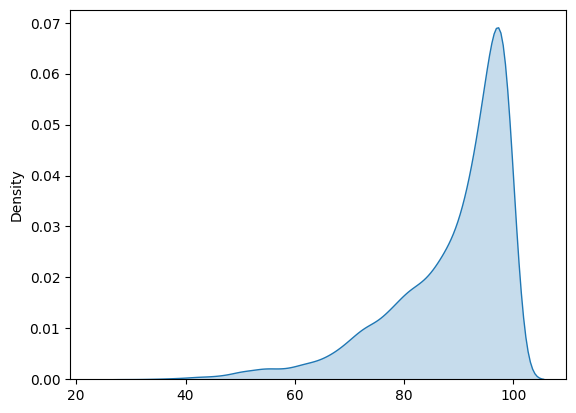

In [77]:
flow = Flow()
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate_flow(flow, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_9608\37579770.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 87.84871249999999


<Axes: ylabel='Density'>

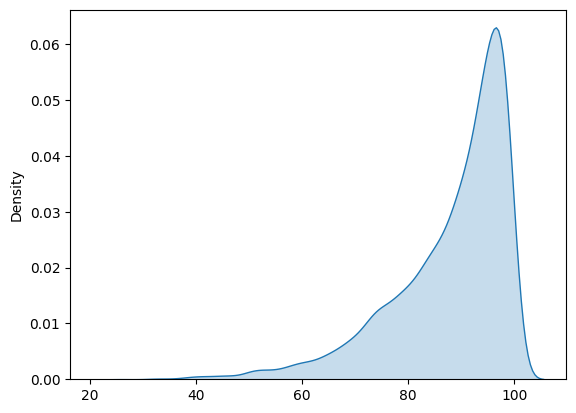

In [78]:
flow = Flow()
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate_flow(flow, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

## Conditional Generation

In [36]:
flow = Flow()
flow.load_state_dict(torch.load(model_path))
flow.eval()

def slider(angle):
    x = generate_flow(flow, angle, num_iter=100)
    X, y = get_moons_dataset()
    X_rotated = rotate(X, angle)
    plot_decision_boundary(x, X_rotated, y, title=f"{angle}° degrees")

from ipywidgets import interact
interact(slider, angle=(0, 360, 1))

interactive(children=(IntSlider(value=180, description='angle', max=360), Output()), _dom_classes=('widget-int…

<function __main__.slider(angle)>

## Parameters distribution

In [29]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()

angle = 0
accuracies = []

X, y = get_moons_dataset()
X = torch.tensor(X, dtype=torch.float32)

for i in range(1000):
    parameters = generate(flow, angle, num_iter=100)[0]
    accuracy = get_accuracy(parameters, X, y)
    accuracies.append(accuracy)
    
print("Mean accuracy:", np.mean(accuracies))

Mean accuracy: 93.38789999999999


(33, 1000)


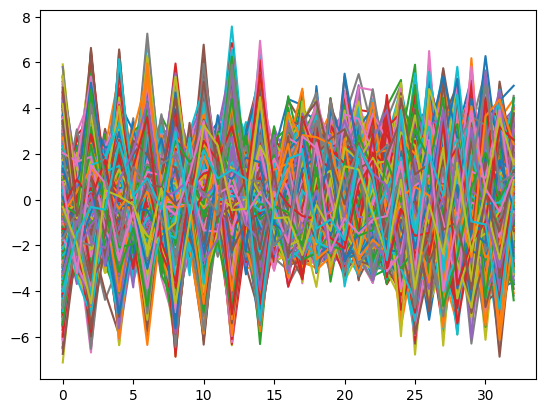

In [19]:
parameters = np.array(parameters)
print(parameters.T.shape)

plt.plot(parameters.T)
plt.show()